## ML Model Gold Standard

### Datasource
    1. https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

### Objective
    1. Uncover the factors that lead to employee attrition.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# --------------- End of sklearn libraries ---------------------

import optuna

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.3  # test_size where used is assigned TESTSIZE

#### I/O Path & File Name

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_IBM_Attrition_34x1.csv"
PREFIX = r"\MLM_V3.0_IBM_Attrition_I1_"

# Specify number of features and targets

n_features = 30
n_target = 1

#### Dataframe Construction

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

#### Encoding

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,Yes
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,No
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,Yes
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,No
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,No


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,2,1102,2,1,2,1,1,1,2,0,94,3,2,7,4,2,5993,19479,8,0,1,11,3,1,80,0,8,0,1,6,4,0,5,1
1,49,1,279,1,8,1,1,1,2,3,1,61,2,2,6,2,1,5130,24907,1,0,0,23,4,4,80,1,10,3,3,10,7,1,7,0
2,37,2,1373,1,2,2,4,1,4,4,1,92,2,1,2,3,2,2090,2396,6,0,1,15,3,2,80,0,7,3,3,0,0,0,0,1
3,33,1,1392,1,3,4,1,1,5,4,0,56,3,1,6,3,1,2909,23159,1,0,1,11,3,3,80,0,8,3,3,8,7,3,0,0
4,27,2,591,1,2,1,3,1,7,1,1,40,3,1,2,2,1,3468,16632,9,0,0,12,3,4,80,1,6,3,3,2,2,2,2,0


#### Imputing

In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

#### Outlier Treatment

In [15]:
# """
#     1. Cell for removing outliers.
#     2. Based on Z-score.
# """
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

List of Targets: ['Attrition']

List of Categorical Variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'Attrition']

List of Categorical Targets ['Attrition']



#### Descriptive Stats

In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |     std |   min |    25% |     50% |     75% |   max |
|--------------------------|---------|---------|---------|-------|--------|---------|---------|-------|
| Age                      |    1470 |  36.924 |   9.135 |    18 |     30 |      36 |      43 |    60 |
| BusinessTravel           |    1470 |   1.607 |   0.665 |     0 |      1 |       2 |       2 |     2 |
| DailyRate                |    1470 | 802.486 | 403.509 |   102 |    465 |     802 |    1157 |  1499 |
| Department               |    1470 |   1.261 |   0.528 |     0 |      1 |       1 |       2 |     2 |
| DistanceFromHome         |    1470 |   9.193 |   8.107 |     1 |      2 |       7 |      14 |    29 |
| Education                |    1470 |   2.913 |   1.024 |     1 |      2 |       3 |       4 |     5 |
| EducationField           |    1470 |   2.248 |   1.331 |     0 |      1 |       2 |       3 |     5 |
| EmployeeCount            |    1470 |       1 |       0 |     1

#### Train-Test Split

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 0    863
1    166
Name: Attrition, dtype: int64
After Upsampling: 0    863
1    863
Name: Attrition, dtype: int64


#### Random Under Sampling

In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,37,1,663,1,11,3,4,1,306,2,1,47,3,3,5,4,0,12185,10056,1,0,1,14,3,3,80,3,10,1,3,10,8,0,7
1,37,2,342,2,16,4,2,1,868,4,1,66,2,2,7,3,0,6334,24558,4,0,0,19,3,4,80,2,9,2,3,1,0,0,0
2,35,2,195,2,1,3,3,1,620,1,0,80,3,2,7,3,2,4859,6698,1,0,0,16,3,4,80,0,5,3,3,5,4,0,3
3,38,2,395,2,9,3,2,1,893,2,1,98,2,1,8,2,1,2899,12102,0,0,0,19,3,4,80,1,3,3,3,2,2,1,2
4,56,2,1443,2,11,5,2,1,1935,4,0,89,2,2,7,1,1,5380,20328,4,0,0,16,3,3,80,1,6,3,3,0,0,0,0


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
598,28,2,890,1,2,4,3,1,828,3,1,46,3,1,6,3,2,4382,16374,6,0,0,17,3,4,80,0,5,3,2,2,2,2,1
116,34,2,1354,1,5,3,3,1,153,3,0,45,2,3,3,1,2,11631,5615,2,0,0,12,3,4,80,0,14,6,3,11,10,5,8
58,31,2,655,1,7,4,1,1,76,4,1,48,3,2,2,4,0,5915,9528,3,0,0,22,4,4,80,1,10,3,2,7,7,1,7
791,35,2,1204,2,4,3,5,1,1100,4,1,86,3,3,7,1,2,9582,10333,0,0,1,22,4,1,80,0,9,2,3,8,7,4,7
465,46,1,1034,1,18,1,3,1,624,1,0,86,3,3,0,3,1,10527,8984,5,0,0,11,3,4,80,0,28,3,2,2,2,1,2


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Attrition
0,0
1,0
2,0
3,0
4,0


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Attrition
598,1
116,0
58,0
791,1
465,0


#### Feature Scaling

In [30]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.175852,-0.980001,-0.347871,-0.533921,0.119609,0.169108,1.215385,0.0,-1.190299,-0.531662,0.792655,-0.903823,0.494025,1.092619,0.155815,1.193419,-1.650456,1.537156,-0.579953,-0.689848,0.0,1.231274,-0.370763,-0.45125,0.296962,0.0,2.617230,0.028513,-1.302060,0.379327,0.621613,1.275504,-0.620297,1.050508
1,0.175852,0.600823,-1.146401,1.280149,0.721491,1.165289,-0.240378,0.0,-0.259339,1.224604,0.792655,0.034418,-0.892458,0.140164,0.950312,0.291957,-1.650456,0.171008,1.409623,0.467273,0.0,-0.812167,0.965779,-0.45125,1.212243,0.0,1.478788,-0.100996,-0.517917,0.379327,-0.799870,-1.012087,-0.620297,-1.012265
2,-0.033184,0.600823,-1.512083,1.280149,-1.084154,0.169108,0.487504,0.0,-0.670154,-1.409796,-1.261583,0.725753,0.494025,0.140164,0.950312,0.291957,1.058709,-0.173389,-1.040648,-0.689848,0.0,-0.812167,0.163854,-0.45125,1.212243,0.0,-0.798097,-0.619031,0.266227,0.379327,-0.168100,0.131709,-0.620297,-0.128219
3,0.280370,0.600823,-1.014556,1.280149,-0.121143,0.169108,-0.240378,0.0,-0.217926,-0.531662,0.792655,1.614613,-0.892458,-0.812290,1.347561,-0.609506,-0.295873,-0.631029,-0.299256,-1.075555,0.0,-0.812167,0.965779,-0.45125,1.212243,0.0,0.340345,-0.878049,0.266227,0.379327,-0.641928,-0.440189,-0.299844,-0.422901
4,2.161698,0.600823,1.592483,1.280149,0.119609,2.161469,-0.240378,0.0,1.508159,1.224604,-1.261583,1.170183,-0.892458,0.140164,0.950312,-1.510968,-0.295873,-0.051741,0.829296,0.467273,0.0,-0.812167,0.163854,-0.45125,0.296962,0.0,0.340345,-0.489522,0.266227,0.379327,-0.957813,-1.012087,-0.620297,-1.012265


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,-0.764811,0.600823,0.216822,-0.533921,-0.963777,1.165289,0.487504,0.0,-0.325600,0.346471,0.792655,-0.953204,0.494025,-0.812290,0.553064,0.291957,1.058709,-0.284764,0.286834,1.238687,0.0,-0.812167,0.431163,-0.451250,1.212243,0.0,-0.798097,-0.619031,0.266227,-0.904434,-0.641928,-0.440189,0.020608,-0.717583
1,-0.137702,0.600823,1.371083,-0.533921,-0.602649,0.169108,0.487504,0.0,-1.443745,0.346471,-1.261583,-1.002585,-0.892458,1.092619,-0.638682,-1.510968,1.058709,1.407803,-1.189228,-0.304141,0.0,-0.812167,-0.905380,-0.451250,1.212243,0.0,-0.798097,0.546548,2.618659,0.379327,0.779555,1.847402,0.981967,1.345190
2,-0.451257,0.600823,-0.367772,-0.533921,-0.361896,1.165289,-0.968260,0.0,-1.571296,1.224604,0.792655,-0.854442,0.494025,0.140164,-1.035930,1.193419,-1.650456,0.073176,-0.652391,0.081566,0.0,-0.812167,1.767705,2.216068,1.212243,0.0,0.340345,0.028513,0.266227,-0.904434,0.147785,0.989555,-0.299844,1.050508
3,-0.033184,0.600823,0.997938,1.280149,-0.723025,0.169108,1.943267,0.0,0.124972,1.224604,0.792655,1.022040,0.494025,1.092619,0.950312,-1.510968,1.058709,0.929383,-0.541951,-1.075555,0.0,1.231274,1.767705,2.216068,-1.533599,0.0,-0.798097,-0.100996,-0.517917,0.379327,0.305728,0.989555,0.661514,1.050508
4,1.116516,-0.980001,0.575041,-0.533921,0.962243,-1.823252,0.487504,0.0,-0.663528,-1.409796,-1.261583,1.022040,0.494025,1.092619,-1.830427,0.291957,-0.295873,1.150030,-0.727024,0.852980,0.0,-0.812167,-1.172688,-0.451250,1.212243,0.0,-0.798097,2.359672,0.266227,-0.904434,-0.641928,-0.440189,-0.299844,-0.422901


### Machine Learning Models

#### Tuning Logistic Regression

In [35]:
def LR_Opt(trial):
    penalty = trial.suggest_categorical("penalty", ['l2'])
    solver = trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear'])
    c_values = trial.suggest_int('C', 1, 1000)
    Log_Reg = LogisticRegression(penalty=penalty, solver=solver, C=c_values, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction
    y_pred = Log_Reg.predict(X_test_sc)

    Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
    Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_LR = CM[1, 1]
    TN_LR = CM[0, 0]
    FP_LR = CM[0, 1]
    FN_LR = CM[1, 0]
    Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
    Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
    f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
    Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
    AUC_LR = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_LR, Precision_LR, Recall_LR

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (LR_Opt, n_trials=100)

[I 2021-08-07 19:49:48,761] A new study created in memory with name: no-name-0d487ca2-5259-465c-b254-0d6006ee07b3
[I 2021-08-07 19:49:48,788] Trial 0 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 468}. 
[I 2021-08-07 19:49:48,817] Trial 1 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 513}. 
[I 2021-08-07 19:49:48,838] Trial 2 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 973}. 
[I 2021-08-07 19:49:48,866] Trial 3 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 618}. 
[I 2021-08-07 19:49:48,880] Trial 4 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 251}. 
[I 2021-08-07 19:49:48,895] Trial 5 finished with values: [0.76, 0.37, 0.66] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 718}. 
[I 2021-08-07 

In [36]:
LR_Best = study.best_trials[0]
LR_Best = LR_Best.params

In [37]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [38]:
LR_Best

{'penalty': 'l2', 'solver': 'newton-cg', 'C': 468}

#### Logistic Regression

In [39]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [40]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [41]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [42]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.92,0.78,0.85,370.00
1,0.37,0.66,0.47,71.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.65,0.72,0.66,441.00
weighted avg,0.83,0.76,0.79,441.00


#### Tuning Ada Boost

In [43]:
def ABC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 600) # Number of Trees in the Forest
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1)
    ABC = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = ABC.predict(X_test_sc)

    Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
    Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ABC = CM[1, 1]
    TN_ABC = CM[0, 0]
    FP_ABC = CM[0, 1]
    FN_ABC = CM[1, 0]
    Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
    Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
    f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
    Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
    AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ABC, Precision_ABC, Recall_ABC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(ABC_Opt, n_trials=100)

[I 2021-08-07 19:49:52,151] A new study created in memory with name: no-name-9b703d0f-ea41-401d-bc50-849455d01b1c
[I 2021-08-07 19:49:53,637] Trial 0 finished with values: [0.81, 0.43, 0.51] and parameters: {'n_estimators': 397, 'learning_rate': 0.865851123463494}. 
[I 2021-08-07 19:49:55,621] Trial 1 finished with values: [0.78, 0.38, 0.62] and parameters: {'n_estimators': 543, 'learning_rate': 0.05285149197584772}. 
[I 2021-08-07 19:49:56,361] Trial 2 finished with values: [0.79, 0.4, 0.55] and parameters: {'n_estimators': 201, 'learning_rate': 0.815413210563454}. 
[I 2021-08-07 19:49:57,648] Trial 3 finished with values: [0.81, 0.42, 0.52] and parameters: {'n_estimators': 348, 'learning_rate': 0.6136851795332707}. 
[I 2021-08-07 19:49:58,779] Trial 4 finished with values: [0.8, 0.4, 0.49] and parameters: {'n_estimators': 308, 'learning_rate': 0.9342711289579705}. 
[I 2021-08-07 19:50:00,782] Trial 5 finished with values: [0.79, 0.4, 0.61] and parameters: {'n_estimators': 547, 'learn

In [44]:
ABC_Best = study.best_trials[0]
ABC_Best = ABC_Best.params

In [45]:
print("------ Ada Boost Best Parameters ------")

------ Ada Boost Best Parameters ------


In [46]:
ABC_Best

{'n_estimators': 540, 'learning_rate': 0.7701633638401186}

In [47]:
#### Ada Boost

In [48]:
# Model: Ada Boost Classifier (ABC) 

ABC = AdaBoostClassifier(**ABC_Best, random_state=RND_STATE)
ABC.fit(X_train_sc, y_train)

# Prediction

y_pred = ABC.predict(X_test_sc)

Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ABC = CM[1, 1]
TN_ABC = CM[0, 0]
FP_ABC = CM[0, 1]
FN_ABC = CM[1, 0]

Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ABC, tpr_ABC, threshold_ABC = roc_curve(y_test, y_pred, pos_label=1)

In [49]:
ABC_Rep = classification_report(y_test, y_pred, output_dict=True)
ABC_Rep_df = pd.DataFrame(ABC_Rep).transpose()

In [50]:
print("-------- Ada Boost Summary -------- ")

-------- Ada Boost Summary -------- 


In [51]:
ABC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.91,0.88,0.89,370.00
1,0.45,0.52,0.48,71.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.68,0.70,0.69,441.00
weighted avg,0.83,0.82,0.82,441.00


#### Tuning Random Forest

In [52]:
def RFC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = RFC.predict(X_test_sc)

    Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
    Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_RFC = CM[1, 1]
    TN_RFC = CM[0, 0]
    FP_RFC = CM[0, 1]
    FN_RFC = CM[1, 0]
    Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
    Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
    f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
    Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
    AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_RFC, Precision_RFC, Recall_RFC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(RFC_Opt, n_trials=100)

[I 2021-08-07 19:51:49,637] A new study created in memory with name: no-name-45978e99-5682-4236-af0e-6998dbcf2873
[I 2021-08-07 19:51:50,290] Trial 0 finished with values: [0.78, 0.37, 0.54] and parameters: {'n_estimators': 300, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}. 
[I 2021-08-07 19:51:51,484] Trial 1 finished with values: [0.81, 0.43, 0.51] and parameters: {'n_estimators': 450, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}. 
[I 2021-08-07 19:51:51,787] Trial 2 finished with values: [0.85, 0.55, 0.41] and parameters: {'n_estimators': 100, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5}. 
[I 2021-08-07 19:51:52,477] Trial 3 finished with values: [0.84, 0.51, 0.49] and parameters: {'n_estimators': 250, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}. 
[I 2021-08-07 19:51:53,792] Trial 4 finished with values: [0.86, 0

In [53]:
RFC_Best = study.best_trials[0]
RFC_Best = RFC_Best.params

In [54]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [55]:
RFC_Best

{'n_estimators': 250,
 'max_features': 'auto',
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_split': 5}

#### Random Forest

In [56]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [57]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [58]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [59]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.90,0.91,0.91,370.00
1,0.51,0.49,0.50,71.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.71,0.70,0.70,441.00
weighted avg,0.84,0.84,0.84,441.00


#### Tuning Extra Trees

In [60]:
def ETC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    ETC = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = ETC.predict(X_test_sc)

    Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
    Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ETC = CM[1, 1]
    TN_ETC = CM[0, 0]
    FP_ETC = CM[0, 1]
    FN_ETC = CM[1, 0]
    Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
    Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
    f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
    Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
    AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ETC, Precision_ETC, Recall_ETC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (ETC_Opt, n_trials=100)

[I 2021-08-07 19:53:13,063] A new study created in memory with name: no-name-db0b81a3-31de-4572-8a3d-4d3ea1dd1a47
[I 2021-08-07 19:53:13,878] Trial 0 finished with values: [0.82, 0.45, 0.56] and parameters: {'n_estimators': 450, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}. 
[I 2021-08-07 19:53:14,521] Trial 1 finished with values: [0.8, 0.42, 0.59] and parameters: {'n_estimators': 400, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 5}. 
[I 2021-08-07 19:53:15,075] Trial 2 finished with values: [0.79, 0.4, 0.61] and parameters: {'n_estimators': 350, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}. 
[I 2021-08-07 19:53:16,350] Trial 3 finished with values: [0.84, 0.51, 0.45] and parameters: {'n_estimators': 600, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5}. 
[I 2021-08-07 19:53:16,714] Trial 4 finished with values: [0.8, 0.42, 0.59

In [61]:
ETC_Best = study.best_trials[0]
ETC_Best = ETC_Best.params

In [62]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [63]:
ETC_Best

{'n_estimators': 450,
 'max_features': 'sqrt',
 'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_split': 5}

#### Extra Trees

In [64]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [65]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [66]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [67]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.90,0.91,0.91,370.00
1,0.51,0.49,0.50,71.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.71,0.70,0.70,441.00
weighted avg,0.84,0.84,0.84,441.00


#### Tuning Kernel SVM

In [68]:
def KSV_Opt(trial):
    c_values = trial.suggest_int('C', 1, 100, 10)
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])
    gamma = trial.suggest_float('gamma', 0.001, 0.01)
    KSV = svm.SVC (kernel=kernel, C=c_values, gamma=gamma, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = KSV.predict(X_test_sc)

    Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
    Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_KSV = CM[1, 1]
    TN_KSV = CM[0, 0]
    FP_KSV = CM[0, 1]
    FN_KSV = CM[1, 0]
    Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
    Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
    f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
    Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
    AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_KSV, Precision_KSV, Recall_KSV

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (KSV_Opt, n_trials=100)

[I 2021-08-07 19:54:14,863] A new study created in memory with name: no-name-c6fd0457-7789-4169-a03b-eb7b289036e6
[I 2021-08-07 19:54:15,232] Trial 0 finished with values: [0.81, 0.42, 0.49] and parameters: {'C': 41, 'kernel': 'rbf', 'gamma': 0.004322845076073788}. 
[I 2021-08-07 19:54:15,658] Trial 1 finished with values: [0.79, 0.4, 0.63] and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.005186359703015401}. 
[I 2021-08-07 19:54:15,837] Trial 2 finished with values: [0.84, 0.49, 0.3] and parameters: {'C': 51, 'kernel': 'poly', 'gamma': 0.008486647147108986}. 
[I 2021-08-07 19:54:16,225] Trial 3 finished with values: [0.82, 0.45, 0.46] and parameters: {'C': 81, 'kernel': 'rbf', 'gamma': 0.005098700665254877}. 
[I 2021-08-07 19:54:16,640] Trial 4 finished with values: [0.82, 0.45, 0.46] and parameters: {'C': 91, 'kernel': 'rbf', 'gamma': 0.004720074995947312}. 
[I 2021-08-07 19:54:16,988] Trial 5 finished with values: [0.82, 0.45, 0.46] and parameters: {'C': 31, 'kernel': 'rbf', 'ga

In [69]:
KSV_Best = study.best_trials[0]
KSV_Best = KSV_Best.params

In [70]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [71]:
KSV_Best

{'C': 31, 'kernel': 'poly', 'gamma': 0.007962009343029468}

#### Kernel SVM

In [72]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [73]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [74]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [75]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.89,0.93,0.91,370.00
1,0.52,0.39,0.45,71.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.70,0.66,0.68,441.00
weighted avg,0.83,0.84,0.83,441.00


#### Tuning CatBoost

In [76]:
def CBC_Opt(trial):
    train_dataset = cb. Pool (X_train_sc, y_train)
    test_dataset = cb.Pool(X_test_sc, y_test)
    
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    depth = trial.suggest_int('depth', 2, 7, 1) 
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 2, 5, 1)
    iterations = trial.suggest_int('iterations', 50, 600, 50)
    CBC = cb.CatBoostClassifier (loss_function='Logloss', random_state=RND_STATE, verbose=False,
    learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, iterations=iterations).fit(X_train_sc, y_train)

# Prediction.
    y_pred = CBC.predict(X_test_sc)

    Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
    Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_CBC = CM[1, 1]
    TN_CBC = CM[0, 0]
    FP_CBC = CM[0, 1]
    FN_CBC = CM[1, 0]
    Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
    Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
    f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
    Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
    AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_CBC, Precision_CBC, Recall_CBC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (CBC_Opt, n_trials=100)

[I 2021-08-07 19:54:48,825] A new study created in memory with name: no-name-c92c0fdb-ace0-438f-99c2-9316b7a225f7
[I 2021-08-07 19:54:50,589] Trial 0 finished with values: [0.87, 0.63, 0.41] and parameters: {'learning_rate': 0.09373725698307943, 'depth': 5, 'l2_leaf_reg': 4, 'iterations': 450}. 
[I 2021-08-07 19:54:51,863] Trial 1 finished with values: [0.83, 0.47, 0.52] and parameters: {'learning_rate': 0.07892206428105594, 'depth': 2, 'l2_leaf_reg': 4, 'iterations': 600}. 
[I 2021-08-07 19:54:52,599] Trial 2 finished with values: [0.8, 0.41, 0.58] and parameters: {'learning_rate': 0.09704900611247201, 'depth': 2, 'l2_leaf_reg': 3, 'iterations': 100}. 
[I 2021-08-07 19:54:54,084] Trial 3 finished with values: [0.85, 0.53, 0.45] and parameters: {'learning_rate': 0.0729177632291718, 'depth': 3, 'l2_leaf_reg': 4, 'iterations': 550}. 
[I 2021-08-07 19:54:55,153] Trial 4 finished with values: [0.82, 0.44, 0.51] and parameters: {'learning_rate': 0.09569185118915445, 'depth': 2, 'l2_leaf_reg

In [77]:
CBC_Best = study.best_trials[0]
CBC_Best = CBC_Best.params

In [78]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [79]:
CBC_Best

{'learning_rate': 0.06953847456697324,
 'depth': 3,
 'l2_leaf_reg': 4,
 'iterations': 50}

#### CatBoost

In [80]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	learn: 0.6742169	total: 6.71ms	remaining: 329ms
1:	learn: 0.6634335	total: 12.5ms	remaining: 301ms
2:	learn: 0.6490706	total: 14ms	remaining: 219ms
3:	learn: 0.6340524	total: 15.4ms	remaining: 177ms
4:	learn: 0.6212196	total: 16.8ms	remaining: 151ms
5:	learn: 0.6107960	total: 18.2ms	remaining: 134ms
6:	learn: 0.6008616	total: 19.6ms	remaining: 120ms
7:	learn: 0.5958026	total: 21.1ms	remaining: 111ms
8:	learn: 0.5911132	total: 22.6ms	remaining: 103ms
9:	learn: 0.5858490	total: 24ms	remaining: 96ms
10:	learn: 0.5795319	total: 25.5ms	remaining: 90.3ms
11:	learn: 0.5754220	total: 26.8ms	remaining: 85ms
12:	learn: 0.5692071	total: 28.2ms	remaining: 80.3ms
13:	learn: 0.5637730	total: 29.6ms	remaining: 76.1ms
14:	learn: 0.5587125	total: 31ms	remaining: 72.3ms
15:	learn: 0.5531935	total: 32.4ms	remaining: 68.8ms
16:	learn: 0.5489974	total: 33.8ms	remaining: 65.6ms
17:	learn: 0.5440438	total: 35.2ms	remaining: 62.6ms
18:	learn: 0.5401466	total: 36.7ms	remaining: 59.8ms
19:	learn: 0.5362874	t

In [81]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [82]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [83]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.92,0.85,0.88,370.00
1,0.43,0.61,0.50,71.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.67,0.73,0.69,441.00
weighted avg,0.84,0.81,0.82,441.00


#### Multi-Layer Perceptron

In [84]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [85]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [86]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [87]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.89,0.93,0.91,370.00
1,0.51,0.39,0.44,71.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.70,0.66,0.68,441.00
weighted avg,0.83,0.84,0.83,441.00


#### Voting Classifier

In [88]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], voting='soft',
                       weights=[1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [89]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [90]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [91]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.91,0.88,0.89,370.00
1,0.45,0.52,0.48,71.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.68,0.70,0.69,441.00
weighted avg,0.83,0.82,0.83,441.00


#### Stacking Classifier

In [92]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [93]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [94]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [95]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.86,0.94,0.90,370.00
1,0.39,0.21,0.28,71.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.63,0.57,0.59,441.00
weighted avg,0.79,0.82,0.80,441.00


### Results & Output

#### Output to Excel

In [96]:
modlst = ['Logistic_Regression', 'Ada_Boost', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_ABC', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC',
          'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_ABC', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC',
          'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_ABC', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_ABC', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_ABC', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_ABC',  'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_ABC', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV',
          'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_ABC',  'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_ABC', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_ABC', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV',
           'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_ABC', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'ABC_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [97]:
print("Evaluation Summary:")

Evaluation Summary:


In [98]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.78,0.76,47,290,80,24,0.37,0.66,0.47,0.78,0.72,"{'penalty': 'l2', 'solver': 'newton-cg', 'C': 468}"
1,Ada_Boost,0.97,0.82,37,324,46,34,0.45,0.52,0.48,0.88,0.7,"{'n_estimators': 540, 'learning_rate': 0.7701633638401186}"
2,Random_Forest,0.93,0.84,35,336,34,36,0.51,0.49,0.5,0.91,0.7,"{'n_estimators': 250, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}"
3,Extra_Trees,0.81,0.78,37,306,64,34,0.37,0.52,0.43,0.83,0.67,"{'n_estimators': 450, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}"
4,Kernel_SVM,0.96,0.84,28,344,26,43,0.52,0.39,0.45,0.93,0.66,"{'C': 31, 'kernel': 'poly', 'gamma': 0.007962009343029468}"
5,CatBoost,0.85,0.81,43,313,57,28,0.43,0.61,0.5,0.85,0.73,"{'learning_rate': 0.06953847456697324, 'depth': 3, 'l2_leaf_reg': 4, 'iterations': 50}"
6,MLP,1.0,0.84,28,343,27,43,0.51,0.39,0.44,0.93,0.66,{}
7,VOC,0.89,0.82,37,325,45,34,0.45,0.52,0.48,0.88,0.7,{}
8,STC,0.97,0.82,15,347,23,56,0.39,0.21,0.27,0.94,0.57,{}


In [99]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, ABC_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'ABC_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [100]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [101]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.92       0.78    0.85      370.00 
           1             0.37       0.66    0.47      71.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.65       0.72    0.66      441.00 
           weighted avg  0.83       0.76    0.79      441.00 
ABC_Rep_df 0             0.91       0.88    0.89      370.00 
           1             0.45       0.52    0.48      71.00  
           accuracy      0.82       0.82    0.82      0.82   
           macro avg     0.68       0.70    0.69      441.00 
           weighted avg  0.83       0.82    0.82      441.00 
RFC_Rep_df 0             0.90       0.91    0.91      370.00 
           1             0.51       0.49    0.50      71.00  
           accuracy      0.84       0.84    0.84      0.84   
           macro avg     0.71       0.70    0.70      441.00 
           weighted avg  0.84       0.84    0.84      441.00 
ETC_Rep_df 0             0.90       0.91    0.91      370.00 
           1             0.51       0.49    0.50      71.00  
           accuracy      0.84       0.84    0.84      0.84   
           macro avg     0.71       0.70    0.70      441.00 
           weighted avg  0.84       0.84    0.84      441.00 
KSV_Rep_df 0             0.89       0.93    0.91      370.00 
           1             0.52       0.39    0.45      71.00  
           accuracy      0.84       0.84    0.84      0.84   
           macro avg     0.70       0.66    0.68      441.00 
           weighted avg  0.83       0.84    0.83      441.00 
CBC_Rep_df 0             0.92       0.85    0.88      370.00 
           1             0.43       0.61    0.50      71.00  
           accuracy      0.81       0.81    0.81      0.81   
           macro avg     0.67       0.73    0.69      441.00 
           weighted avg  0.84       0.81    0.82      441.00 
MLP_Rep_df 0             0.89       0.93    0.91      370.00 
           1             0.51       0.39    0.44      71.00  
           accuracy      0.84       0.84    0.84      0.84   
           macro avg     0.70       0.66    0.68      441.00 
           weighted avg  0.83       0.84    0.83      441.00 
VOC_Rep_df 0             0.91       0.88    0.89      370.00 
           1             0.45       0.52    0.48      71.00  
           accuracy      0.82       0.82    0.82      0.82   
           macro avg     0.68       0.70    0.69      441.00 
           weighted avg  0.83       0.82    0.83      441.00 
STC_Rep_df 0             0.86       0.94    0.90      370.00 
           1             0.39       0.21    0.28      71.00  
           accuracy      0.82       0.82    0.82      0.82   
           macro avg     0.63       0.57    0.59      441.00 
           weighted avg  0.79       0.82    0.80      441.00

#### ROC Curve

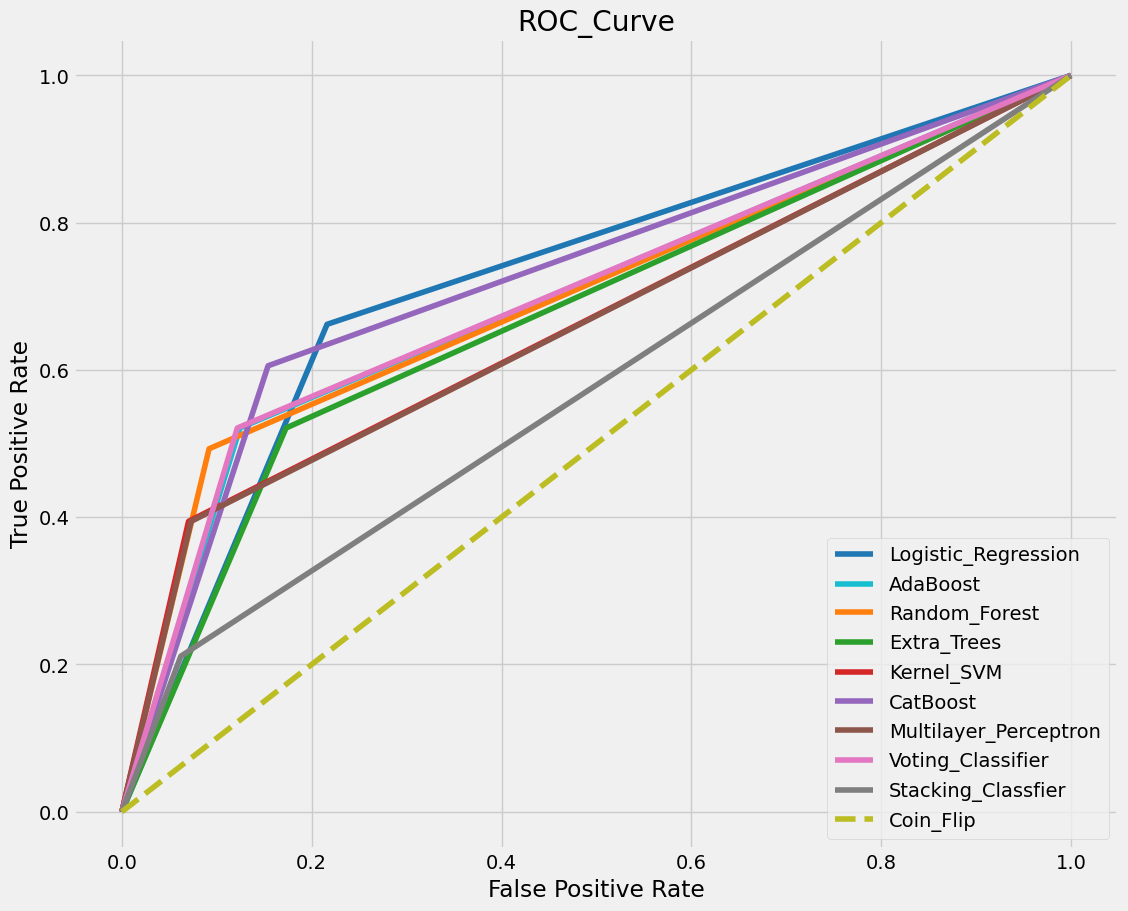

In [102]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_ABC, tpr_ABC, linestyle='-', color='tab:cyan', label='AdaBoost')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([-0.05, 1.05])
plt.ylim([-.05, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

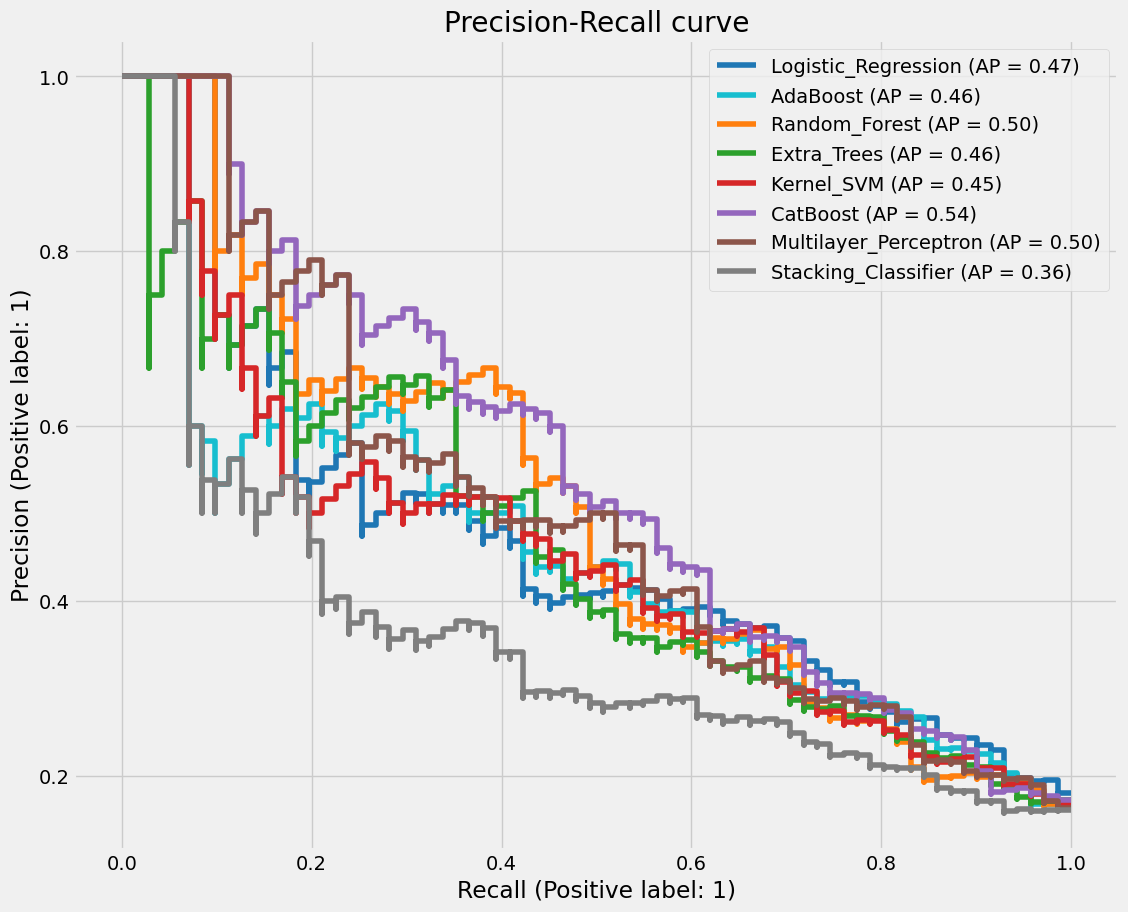

In [103]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(ABC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:cyan', name = "AdaBoost")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()

#### SHAP Model Explainer

In [104]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [105]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


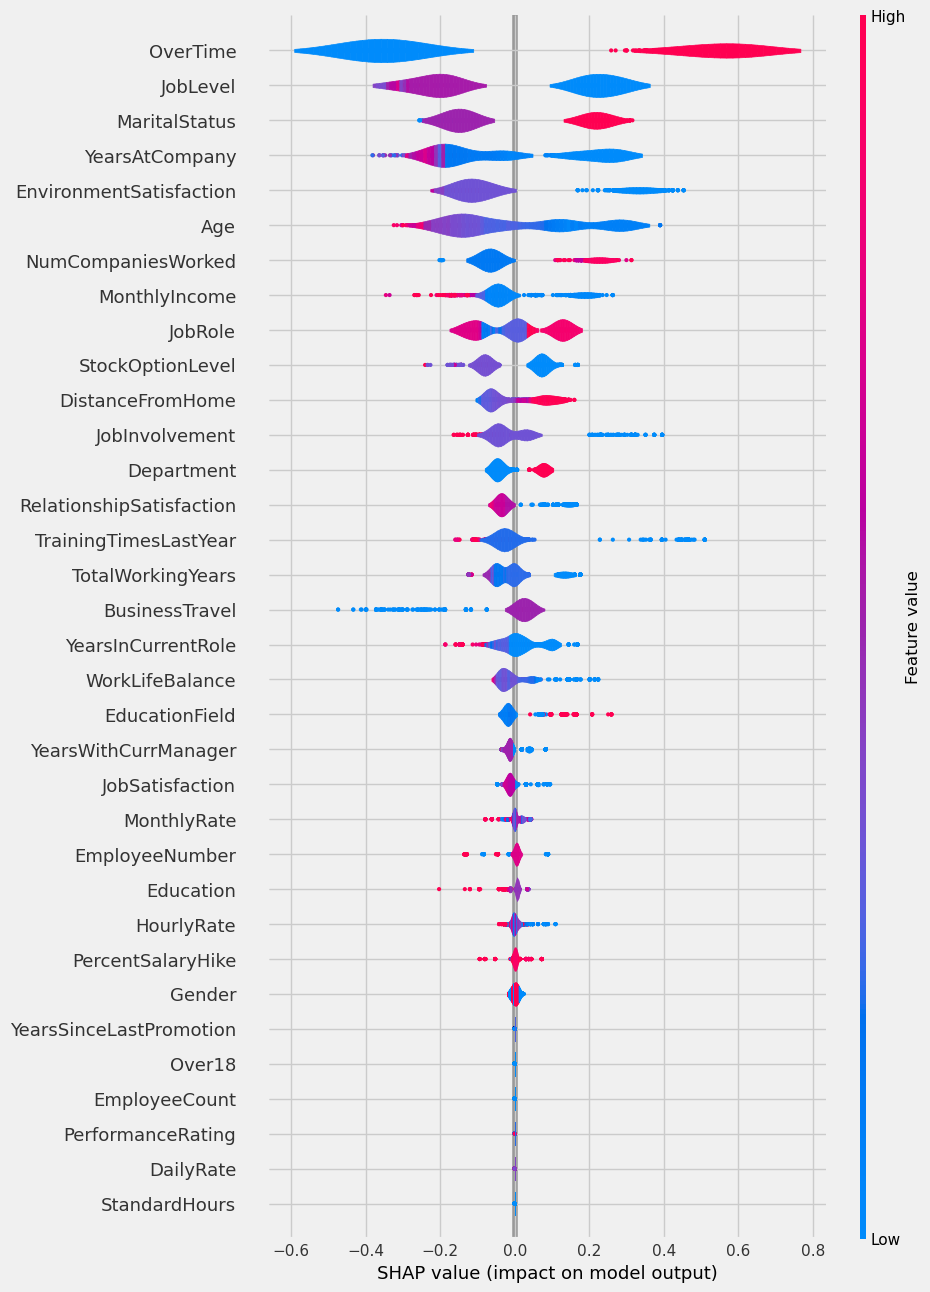

In [106]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [107]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [108]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [110]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V3.0_IBM_Attrition.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass

[NbConvertApp] Converting notebook GS_MLM_CLF_V3.0_IBM_Attrition.ipynb to html_toc
[NbConvertApp] Support files will be in MLM_V3.0_IBM_Attrition_I1_files\
[NbConvertApp] Making directory MLM_V3.0_IBM_Attrition_I1_files
[NbConvertApp] Making directory MLM_V3.0_IBM_Attrition_I1_files
[NbConvertApp] Making directory MLM_V3.0_IBM_Attrition_I1_files
[NbConvertApp] Writing 714252 bytes to MLM_V3.0_IBM_Attrition_I1.html
